<a href="https://colab.research.google.com/github/Dominika26/UMWF/blob/main/Case3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stwórz model generujący sygnały kupna i sprzedaży na rynku

Decyzje ma generować jeden z algorytmów uczenia maszynowego, po optymalizacji hiperparametrów

Zrób backtest wybranego modelu, użyj biblioteki przystosowanej do backtestów

Pamiętaj o wnioskach i wizualizacji wyników

4 pkt z oceny będą zależne od wyników inwestycji

Inwestujesz w wylosowaną spółkę przez określony okres, ale można wykorzystać także inne dane niż historyczne (np. obliczone wskaźniki)

Najpierw te sygnały generujemy, potem backtesting
Generowanie sygnałów za pomocą uczenia maszynowego - możemy tylko przewidywać czy wzrost czy spadek
Możemy wybrać jakąś strategię tego kupna/sprzedaży
jakaś hiperparametryzacja , np. jakieś take profity na różnych poziomach

Dane się pobiera z jakiegoś Yahoo finance w zależności od wylosowanej spółki - można też samem zadecydować ile tych danych - można te dane też trochę oszukać - może jednak lepiej na jakimś krótszym okresie, bo wcześniej był covid - ale to są technologiczne więc raczej nie powinno być problemów

In [1]:
!pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=bff587878ce7693f6d6eb1e87fca5d402d30562cab9a32f35a23e0d9f6b0bddb
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [2]:
from backtesting import Backtest
from backtesting.test import EURUSD, GOOG
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
import pandas as pd

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import pandas as pd
import datetime as dt
from pandas_datareader import DataReader
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '
/usr/local/lib/python3.10/dist-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
/usr/local/lib/python3.10/dist-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-cons

****

**Pobranie danych dla firmy Amazon**

Dane treningowe

In [20]:
#the start and end date
start_date = dt.datetime(2019,1,1)
end_date = dt.datetime(2023,12,30)

#loading from yahoo finance
data = yf.download("AMZN",start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [21]:
print(data.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-01-02  73.260002  77.667999  73.046501  76.956497  76.956497  159662000
2019-01-03  76.000504  76.900002  74.855499  75.014000  75.014000  139512000
2019-01-04  76.500000  79.699997  75.915497  78.769501  78.769501  183652000
2019-01-07  80.115501  81.727997  79.459503  81.475502  81.475502  159864000
2019-01-08  83.234497  83.830498  80.830498  82.829002  82.829002  177628000


In [22]:
data.reset_index(inplace=True)
data = data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

Prosty model bez hiperparametryzacji

In [23]:
model = Prophet(daily_seasonality=True)
model.fit(data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpf173gq0y/qmpm461z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf173gq0y/6w_13d3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72508', 'data', 'file=/tmp/tmpf173gq0y/qmpm461z.json', 'init=/tmp/tmpf173gq0y/6w_13d3h.json', 'output', 'file=/tmp/tmpf173gq0y/prophet_model54yadkhh/prophet_model-20240527095616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:56:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:56:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Testowanie

In [24]:
future = model.make_future_dataframe(periods=157)  # od 2024-01-01 do 2024-06-06 to 157 dni
forecast = model.predict(future)

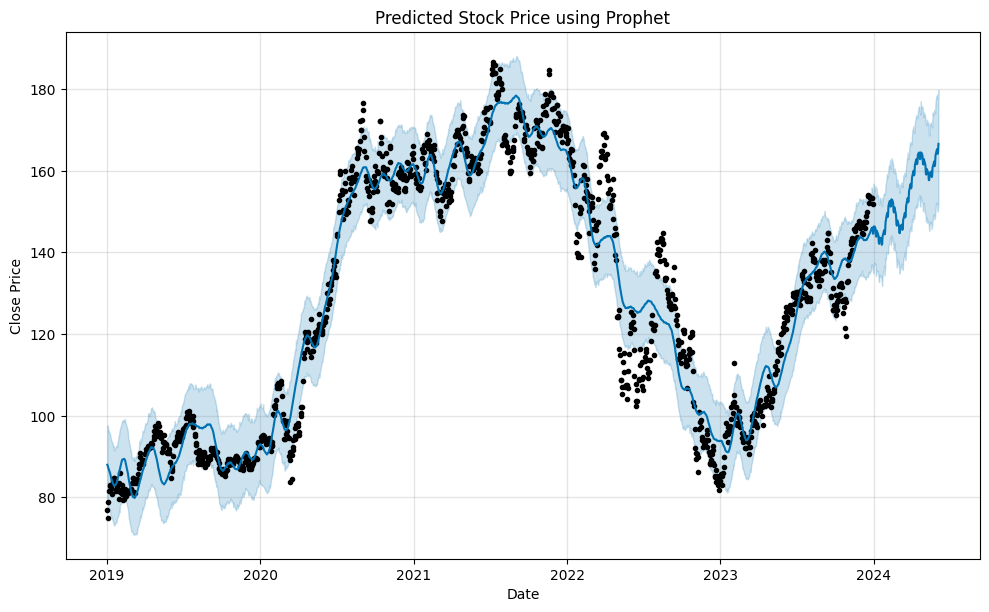

In [25]:
model.plot(forecast)
plt.title(f"Predicted Stock Price using Prophet")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

Hiperparametryzacja modelu

In [50]:
param_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(param_grid)

In [51]:
#tutaj może porawić, żeby za każdym razem brał inny okres
train = data[data['ds'] < '2023-01-01']
validation = data[data['ds'] >= '2023-01-01']


# Krok 4: Przeprowadź siatkę wyszukiwania
best_params = None
best_error = float('inf')

for params in ParameterGrid(param_grid):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_mode = params['seasonality_mode'],
        holidays_prior_scale=params['holidays_prior_scale'],
        weekly_seasonality=True,
        daily_seasonality = True,
        yearly_seasonality = True,
        interval_width=0.95
    )
    model.fit(train)

    # Przewiduj dla zbioru walidacyjnego
    future = model.make_future_dataframe(periods=len(validation), include_history=False)
    forecast = model.predict(future)

    # Oblicz błąd średniej bezwzględnej (MAE) dla walidacji
    mae = mean_absolute_error(validation['y'], forecast['yhat'])

    if mae < best_error:
        best_error = mae
        best_params = params

DEBUG:cmdstanpy:input tempfile: /tmp/tmpf173gq0y/nq5cx7q7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf173gq0y/pfyffa30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41545', 'data', 'file=/tmp/tmpf173gq0y/nq5cx7q7.json', 'init=/tmp/tmpf173gq0y/pfyffa30.json', 'output', 'file=/tmp/tmpf173gq0y/prophet_model7s_0vc8n/prophet_model-20240527102509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:25:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf173gq0y/tif2esdo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf173gq0y/e60kvmj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Model z najelpszymi parametrami

In [52]:
best_model = Prophet(**best_params)
best_model.fit(data)
print(data.tail())
future = best_model.make_future_dataframe(periods=157)  # od 2024-01-01 do 2024-06-06 to 157 dni
print(future)
forecast = best_model.predict(future)
print(forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf173gq0y/q2occ533.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf173gq0y/socmt0a5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48603', 'data', 'file=/tmp/tmpf173gq0y/q2occ533.json', 'init=/tmp/tmpf173gq0y/socmt0a5.json', 'output', 'file=/tmp/tmpf173gq0y/prophet_model2dcbi4pn/prophet_model-20240527102914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:29:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:29:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds           y
1253 2023-12-22  153.419998
1254 2023-12-26  153.410004
1255 2023-12-27  153.339996
1256 2023-12-28  153.380005
1257 2023-12-29  151.940002
             ds
0    2019-01-02
1    2019-01-03
2    2019-01-04
3    2019-01-07
4    2019-01-08
...         ...
1410 2024-05-30
1411 2024-05-31
1412 2024-06-01
1413 2024-06-02
1414 2024-06-03

[1415 rows x 1 columns]
             ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2019-01-02   82.762112   75.913032   91.192422    82.762112    82.762112   
1    2019-01-03   82.838938   75.614385   90.800070    82.838938    82.838938   
2    2019-01-04   82.915764   75.267981   90.471890    82.915764    82.915764   
3    2019-01-07   83.146242   76.009651   90.014115    83.146242    83.146242   
4    2019-01-08   83.223068   75.497434   90.113832    83.223068    83.223068   
...         ...         ...         ...         ...          ...          ...   
1410 2024-05-30  172.487631  157.146242  186.938

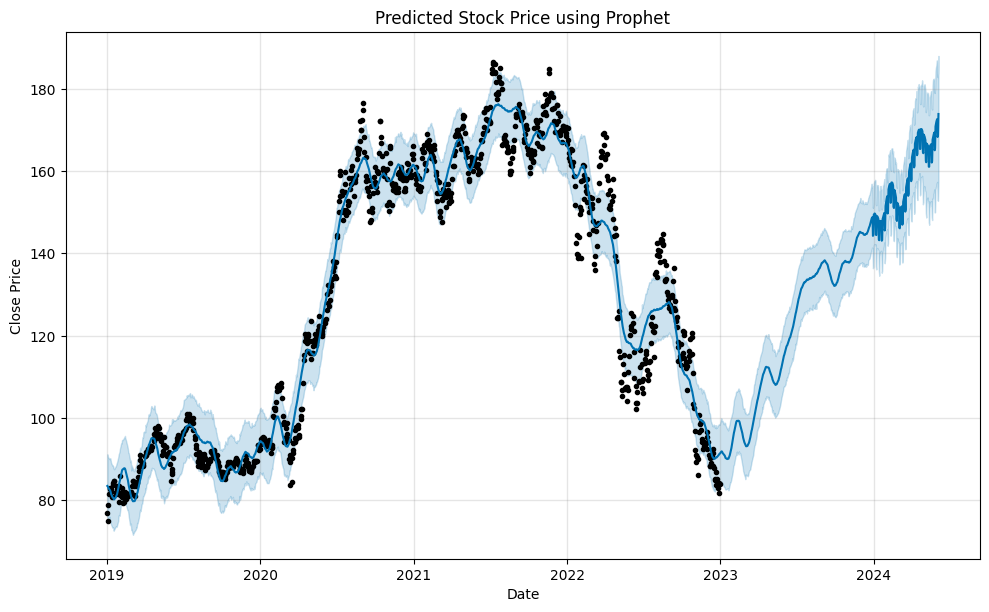

In [53]:
model.plot(forecast)
plt.title(f"Predicted Stock Price using Prophet")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

Stworzenie strategii

In [67]:
future_dates = pd.date_range(start='2024-01-01', end='2024-05-06', freq='B')  # tylko dni robocze

future = pd.DataFrame(future_dates, columns=['ds'])
forecast = best_model.predict(future)
# Dodaj prognozy do danych testowych
forecast.set_index('ds', inplace=True)
forecast = forecast[['yhat_upper']]
print(forecast.index)
if "2024-01-02" in forecast.index:
  print("jest")

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22',
               '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26',
               '2024-01-29', '2024-01-30', '2024-01-31', '2024-02-01',
               '2024-02-02', '2024-02-05', '2024-02-06', '2024-02-07',
               '2024-02-08', '2024-02-09', '2024-02-12', '2024-02-13',
               '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-19',
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29',
               '2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06',
               '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-18',
      

In [70]:
test_data = yf.download("AMZN", start='2024-01-01', end='2024-05-06')
#test_data.reset_index(inplace=True)
#test_data['Date'] = pd.to_datetime(test_data['Date'])
#test_data.set_index('Date', inplace=True)
#print(test_data.head())
print(test_data.index)

[*********************100%%**********************]  1 of 1 completed

DatetimeIndex(['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
               '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11',
               '2024-01-12', '2024-01-16', '2024-01-17', '2024-01-18',
               '2024-01-19', '2024-01-22', '2024-01-23', '2024-01-24',
               '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30',
               '2024-01-31', '2024-02-01', '2024-02-02', '2024-02-05',
               '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09',
               '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15',
               '2024-02-16', '2024-02-20', '2024-02-21', '2024-02-22',
               '2024-02-23', '2024-02-26', '2024-02-27', '2024-02-28',
               '2024-02-29', '2024-03-01', '2024-03-04', '2024-03-05',
               '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-11',
               '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15',
               '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
      

In [72]:
#sprawdzanie czy przewidywana jest wyższ od dzisiejszej, jak tak to kupować, jak niższe to sprzedawać
#zobaczyć czy bez średniej ruchomej jest lepiej, czyli wyrzucić crossover(self.sma1, self.sma2)

class ProphetSmaCrossOptimized(Strategy):
    n1 = 10
    n2 = 20
    sl_percent = 0.01
    tp_percent = 0.05

    def init(self):
        close = self.data.Close
        #self.sma1 = self.I(SMA, close, self.n1)
        #self.sma2 = self.I(SMA, close, self.n2)
        self.forecast = forecast

    def next(self):
        print(self.data)
        date = self.data.index[-1]

        if date in self.forecast.index:
            predicted = self.forecast.loc[date, 'yhat_upper']
            price = self.data.Close[-1]
            print(date)
            print(predicted)
            print(price)
            if price < predicted: #crossover(self.sma1, self.sma2) and price < predicted:
              print("wieksza")
              long_sl = price * (1 - self.sl_percent)
              long_tp = price * (1 + self.tp_percent)
              if self.position.is_short:
                  self.position.close()
              if not self.position.is_long:
                  self.buy(size=0.6, sl=long_sl, tp=long_tp)

            #elif #crossover(self.sma2, self.sma1) and price > predicted:
            elif price > predicted:
              print("Mniejsza")
              short_sl = price * (1 + self.sl_percent)
              short_tp = price * (1 - self.tp_percent)
              if self.position.is_long:
                  self.position.close()
              if not self.position.is_short:
                  self.sell(size=0.6, sl=short_sl, tp=short_tp)

param_grid = {
    'n1': [5, 10, 15],
    'n2': [20, 30, 40],
    'sl_percent': [0.01, 0.02, 0.03],
    'tp_percent': [0.03, 0.05, 0.07]
}

best_stats = None
best_params1 = None

for params in ParameterGrid(param_grid):
    ProphetSmaCrossOptimized.n1 = params['n1']
    ProphetSmaCrossOptimized.n2 = params['n2']
    ProphetSmaCrossOptimized.sl_percent = params['sl_percent']
    ProphetSmaCrossOptimized.tp_percent = params['tp_percent']

    # bt = Backtest(test_data, ProphetSmaCrossOptimized, cash=10000, commission=.002)
    bt = Backtest(test_data, ProphetSmaCrossOptimized, cash=10000)
    stats = bt.run()

    if best_stats is None or stats['Return [%]'] > best_stats['Return [%]']:
        best_stats = stats
        best_params1 = params

# Wyświetl najlepsze parametry i statystyki
print("Najlepsze parametry:", best_params1)
print(best_stats)

# Przeprowadź backtesting z najlepszymi parametrami
ProphetSmaCrossOptimized.n1 = best_params1['n1']
ProphetSmaCrossOptimized.n2 = best_params1['n2']
ProphetSmaCrossOptimized.sl_percent = 0.01 #best_params1['sl_percent']
ProphetSmaCrossOptimized.tp_percent = best_params1['tp_percent']

# bt = Backtest(test_data, ProphetSmaCrossOptimized, cash=10000, commission=.002)
bt = Backtest(test_data, ProphetSmaCrossOptimized, cash=10000)
final_stats = bt.run()
bt.plot()

# Wyświetl ostateczne statystyki
print(final_stats)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
164.84651887515594
174.4499969482422
Mniejsza
<Data i=29 (2024-02-13 00:00:00) Open=167.72999572753906, High=170.9499969482422, Low=165.75, Close=168.63999938964844, Adj Close=168.63999938964844, Volume=56345100.0>
2024-02-12 00:00:00
164.97124099659496
172.33999633789062
Mniejsza
<Data i=30 (2024-02-14 00:00:00) Open=169.2100067138672, High=171.2100067138672, Low=168.27999877929688, Close=170.97999572753906, Adj Close=170.97999572753906, Volume=42815500.0>
2024-02-13 00:00:00
165.05100747949362
168.63999938964844
Mniejsza
<Data i=31 (2024-02-15 00:00:00) Open=170.5800018310547, High=171.1699981689453, Low=167.58999633789062, Close=169.8000030517578, Adj Close=169.8000030517578, Volume=49855200.0>
2024-02-14 00:00:00
165.18605713669623
170.97999572753906
Mniejsza
<Data i=32 (2024-02-16 00:00:00) Open=168.74000549316406, High=170.4199981689453, Low=167.1699981689453, Close=169.50999450683594, Adj Close=169.50999450683594, 

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   97.674419
Equity Final [$]                 10817.009095
Equity Peak [$]                  11323.784928
Return [%]                           8.170091
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                   25.875733
Volatility (Ann.) [%]               15.020618
Sharpe Ratio                         1.722681
Sortino Ratio                        4.123062
Calmar Ratio                         3.427239
Max. Drawdown [%]                   -7.550023
Avg. Drawdown [%]                   -2.001301
Max. Drawdown Duration       71 days 00:00:00
Avg. Drawdown Duration       18 days 00:00:00
# Trades                                   49
Win Rate [%]                        28.571429
Best Trade [%]                       8.545588
Worst Trade [%]                     -2.602557
Avg. Trade [%]                    